In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import f_classif
from scipy.stats import chi2_contingency

import plotly.offline as py
py.init_notebook_mode(connected=True) 
import plotly.graph_objs as go 
import plotly.tools as tls 
import warnings 
from collections import Counter

from sklearn.model_selection import train_test_split, KFold,RepeatedStratifiedKFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score,auc,roc_auc_score, confusion_matrix, classification_report,precision_recall_curve, fbeta_score #To evaluate our model
from sklearn.utils import resample
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_excel(r'C:\Users\MSPP\Credit\credit_risk_model\python\german\german_credit_data.xlsx', index_col=0)
# df = pd.read_excel(r'C:\Users\marcu\Documents\credit\german_credit_data.xlsx', index_col=0)
print(df.columns)
df = df.drop('Unnamed: 11', axis=1) #empty collum
df.head(5)

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk', 'Unnamed: 11'],
      dtype='object')


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio_TV,good
1,22,female,2,own,little,moderate,5951,48,radio_TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture_equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [3]:
df.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

In [4]:
df['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [5]:
df['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [6]:
# df[['Saving accounts','Checking account']].fillna('NA', inplace=True)
df = df.fillna('NA')

In [7]:
df.isna().sum()

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64

In [8]:
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit'
    )

data = [trace0, trace1]

layout = go.Layout(
    
)

layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

In [9]:
def iv_woe(df_x, target, bins=10, show_iv=False, show_woe=False, numeric_fillna=np.inf, precision=3):

    data = df_x

    # Empty Dataframe
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()

    # Extract Column Names
    cols = data.columns

    for col in cols:
        # get dtype for column
        dt = data[col].dtype
        # check if it is a number
        if dt == 'int64' or dt == 'float64':
            data[col].fillna(numeric_fillna, inplace=True)
        else:
            data[col].fillna("None", inplace=True)
#         print(col, dt)

    # Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop', precision=precision)
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'],
                                          0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])     
        d.insert(loc=0, column='Variable', value=ivars)

        ### risco relativo

        d['num']=d['Events']/d['N']
        d['den']=None

        for v in d.Variable.unique():
            for c in d.loc[d.Variable==v].Cutoff:
                x=d.loc[(d.Variable==v)&(d.Cutoff!=c)][['Events','N']].agg('sum')
                d.loc[(d.Variable==v)&(d.Cutoff==c), 'den']=(x['Events']/(x['N']))

        d['RR']=d['num']/(d['den'])
        d.drop(['num', 'den'], axis=1, inplace=True)
        
        ########################
        
        temp = pd.DataFrame({"Variable": [ivars], "IV": [
                            d['IV'].sum()]}, columns=["Variable", "IV"])
        woeDF = pd.concat([woeDF, d], axis=0)
        newDF = pd.concat([newDF, temp], axis=0)
        newDF['IV_Class'] = np.where(
            newDF['IV'] <= 0.02, 'super_weak',
            np.where(newDF['IV'].between(0.02, 0.1, inclusive=True), 'weak',
                     np.where(newDF['IV'].between(0.1, 0.3, inclusive=True), 'medium',
                              np.where(newDF['IV'].between(
                                  0.3, 0.5, inclusive=True), 'strong', 'super_strong')
                              )
                     )
        )
        
        # Show WOE Table
        if show_woe == True:
            print(d)

        # Show IV
        if show_iv == True:
            print("Information value of " + ivars +
                  " is " + str(round(d['IV'].sum(), 6)))

    return newDF, woeDF
#     return newDF, woeDF

In [10]:
# df['Risk'].unique()
df['Risk'] = np.where(df.Risk == "good", 0,1)
df

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NA,little,1169,6,radio_TV,0
1,22,female,2,own,little,moderate,5951,48,radio_TV,1
2,49,male,1,own,little,NA,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture_equipment,0
4,53,male,2,free,little,little,4870,24,car,1
...,...,...,...,...,...,...,...,...,...,...
995,31,female,1,own,little,NA,1736,12,furniture_equipment,0
996,40,male,3,own,little,little,3857,30,car,0
997,38,male,2,own,little,NA,804,12,radio_TV,0
998,23,male,2,free,little,little,1845,45,radio_TV,1


In [20]:
x,y = iv_woe(df.copy(), "Risk")

In [21]:
x

,Variable,IV,IV_Class
0,Age,0.100622,medium
0,Sex,0.026543,weak
0,Job,0.008763,super_weak
0,Housing,0.083293,weak
0,Saving accounts,0.196010,medium
0,Checking account,0.666012,super_strong
0,Credit amount,0.113637,medium
0,Duration,0.246542,medium
0,Purpose,0.067309,weak
0,Agge_class,0.067286,weak


mas analises dos IVs mostram que job nao é uma variavel relevante, IV muito baixo

In [22]:
pd.set_option('display.max_rows', 111100)
y

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,RR
0,Age,"(18.999, 23.0]",105,42,0.140000,63,0.090000,0.441833,0.022092,1.387597
1,Age,"(23.0, 26.0]",135,52,0.173333,83,0.118571,0.379701,0.020793,1.343489
2,Age,"(26.0, 28.0]",94,28,0.093333,66,0.094286,-0.010152,0.000010,0.992178
3,Age,"(28.0, 30.0]",77,26,0.086667,51,0.072857,0.173569,0.002397,1.137454
4,Age,"(30.0, 33.0]",105,33,0.110000,72,0.102857,0.067139,0.000480,1.053505
5,Age,"(33.0, 36.0]",111,23,0.076667,88,0.125714,-0.494545,0.024256,0.665008
6,Age,"(36.0, 39.0]",74,18,0.060000,56,0.080000,-0.287682,0.005754,0.798735
7,Age,"(39.0, 45.0]",113,31,0.103333,82,0.117143,-0.125434,0.001732,0.904596
8,Age,"(45.0, 52.0]",90,18,0.060000,72,0.102857,-0.538997,0.023100,0.64539
9,Age,"(52.0, 75.0]",96,29,0.096667,67,0.095714,0.009901,0.000009,1.007688


In [14]:
df['Agge_class'] = np.where(df.Age.between(18,27),'18-27',
                          np.where(df.Age.between(28,33),'28-33',
                                  np.where(df.Age.between(34,45),'34-45','46+')))

In [15]:
df['Savings_class'] = np.where(df['Saving accounts'].isin(['quite rich', 'rich']), 'rich', df['Saving accounts'])

In [16]:
df['Durration_class'] = np.where(df.Duration.between(9,15), '9-15',
                                np.where(df.Duration.between(3.999,9), '3.999-9',
                                    np.where(df.Duration.between(16,30), '16-30',
                                       np.where(df.Duration.between(31,36), '31-36','36+'))))

In [17]:
df['Purrpose_class'] = np.where(df['Purpose'].isin(['repairs', 'vacation_others', 'domestic appliances', 
                                             ]),'family appliances', df['Purpose'])

In [18]:
df['Crediit_amount_class'] = np.where(df['Credit amount'].between(249.999, 932.0), '250-932',
                                np.where(df['Credit amount'].between(932.0, 1262.0), '932-1262',
                                    np.where(df['Credit amount'].between(1262.0, 1479.4), '1262-1479.4',
                                        np.where(df['Credit amount'].between(1479.4, 1906.8), '1479.4-1906.8',
                                            np.where(df['Credit amount'].between(1906.8, 2319.5), '1906.8-2319.5',
                                                np.where(df['Credit amount'].between(2319.5, 2852.4), '2319.5-2852.4',
                                                    np.where(df['Credit amount'].between(2852.4, 3590.0), '2852.4-3590.0',
                                                         np.where(df['Credit amount'].between(4720.0, 7179.4), '4720.0-7179.4',
                                                             np.where(df['Credit amount'].between(7179.4, 18424.0), '7179.4-18424.0', '18424.0+')))))))))

In [19]:
df['Durration_class'] = np.where(df['Duration'].between(3.999, 9.0), '3.999-9.0',
                                np.where(df['Duration'].between(9.0, 12.0), '9.0-12.0',
                                    np.where(df['Duration'].between(12.0, 15.0), '12.0-15.0',
                                        np.where(df['Duration'].between(15.0, 18.0), '15.0-18.0',
                                            np.where(df['Duration'].between(18.0, 24.0), '18.0-24.0',
                                                np.where(df['Duration'].between(24.0, 30.0), '24.0-30.0',
                                                    np.where(df['Duration'].between(30.0, 36.0), '30.0-36.0',
                                                         np.where(df['Duration'].between(36.0, 72.0), '36.0-72.0','72+'
                                                            ))))))))

In [19]:
a = b

NameError: name 'b' is not defined

#### Preparação de um dataframe para receber os scores no final

In [23]:
df_score = y
df_score

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,RR
0,Age,"(18.999, 23.0]",105,42,0.140000,63,0.090000,0.441833,0.022092,1.387597
1,Age,"(23.0, 26.0]",135,52,0.173333,83,0.118571,0.379701,0.020793,1.343489
2,Age,"(26.0, 28.0]",94,28,0.093333,66,0.094286,-0.010152,0.000010,0.992178
3,Age,"(28.0, 30.0]",77,26,0.086667,51,0.072857,0.173569,0.002397,1.137454
4,Age,"(30.0, 33.0]",105,33,0.110000,72,0.102857,0.067139,0.000480,1.053505
5,Age,"(33.0, 36.0]",111,23,0.076667,88,0.125714,-0.494545,0.024256,0.665008
6,Age,"(36.0, 39.0]",74,18,0.060000,56,0.080000,-0.287682,0.005754,0.798735
7,Age,"(39.0, 45.0]",113,31,0.103333,82,0.117143,-0.125434,0.001732,0.904596
8,Age,"(45.0, 52.0]",90,18,0.060000,72,0.102857,-0.538997,0.023100,0.64539
9,Age,"(52.0, 75.0]",96,29,0.096667,67,0.095714,0.009901,0.000009,1.007688


In [24]:
df_score_clean = df_score[df_score['Variable'].str.contains("Age|Job|Saving accounts|Credit amount|Duration|Purpose|Duration") == False]
df_score_clean 

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV,RR
0,Sex,female,310,109,0.363333,201,0.287143,0.235341,0.017931,1.270225
1,Sex,male,690,191,0.636667,499,0.712857,-0.113035,0.008612,0.787262
0,Housing,free,108,44,0.146667,64,0.091429,0.472604,0.026106,1.41956
1,Housing,own,713,186,0.620000,527,0.752857,-0.194156,0.025795,0.656751
2,Housing,rent,179,70,0.233333,109,0.155714,0.404445,0.031393,1.395919
0,Checking account,NA,394,46,0.153333,348,0.497143,-1.176263,0.404410,0.278548
1,Checking account,little,274,135,0.450000,139,0.198571,0.818099,0.205693,2.167883
2,Checking account,moderate,269,105,0.350000,164,0.234286,0.401392,0.046447,1.463254
3,Checking account,rich,63,14,0.046667,49,0.070000,-0.405465,0.009461,0.72805
0,Agge_class,18-27,291,107,0.356667,184,0.262857,0.305191,0.028630,1.350765


In [25]:
df_score_clean = df_score_clean.drop('RR', axis=1)
df_score_clean = df_score_clean.drop('N', axis=1)
df_score_clean = df_score_clean.drop('Events', axis=1)
df_score_clean = df_score_clean.drop('% of Events', axis=1)
df_score_clean = df_score_clean.drop('Non-Events', axis=1)
df_score_clean = df_score_clean.drop('% of Non-Events', axis=1)
df_score_clean

,Variable,Cutoff,WoE,IV
0,Sex,female,0.235341,0.017931
1,Sex,male,-0.113035,0.008612
0,Housing,free,0.472604,0.026106
1,Housing,own,-0.194156,0.025795
2,Housing,rent,0.404445,0.031393
0,Checking account,NA,-1.176263,0.404410
1,Checking account,little,0.818099,0.205693
2,Checking account,moderate,0.401392,0.046447
3,Checking account,rich,-0.405465,0.009461
0,Agge_class,18-27,0.305191,0.028630


### Preparação para a regressao com os WoEs

In [26]:
df['Age_class_woe'] = np.where(df.Agge_class == '18-27',0.305191,
                             np.where(df.Agge_class == '28-33',0.134083,
                                     np.where(df.Agge_class == '34-45', -0.024573,
                                             np.where(df.Agge_class == '46+', -0.009933, 0))))

In [27]:
df['Savings_class_woe'] = np.where(df.Savings_class == 'NA', -0.704246,
                             np.where(df.Savings_class == 'little',0.271358,
                                     np.where(df.Savings_class == 'moderate',0.139552,
                                             np.where(df.Savings_class == 'rich', -0.862784, 0))))

In [28]:
df['Duration_class_woe'] = np.where(df.Durration_class == '3.999-9', -0.753772,
                            np.where(df.Durration_class == '9.0-12.0', -0.301325,
                             np.where(df.Durration_class == '12.0-15.0', -0.665290,
                                     np.where(df.Durration_class == '15.0-18.0',0.331832,
                                              np.where(df.Durration_class == '18.0-24.0',-0.025642,
                                             np.where(df.Durration_class == '24.0-30.0', 0.154151,
                                                     np.where(df.Durration_class == '30.0-36.0', 0.613683 ,
                                                              np.where(df.Durration_class == '36.0-72.0', 0.916291 ,0))))))))

In [29]:
df['Purpose_class_woe'] = np.where(df.Purrpose_class == 'business', 0.230524,
                             np.where(df.Purrpose_class == 'car', 0.068319,
                                np.where(df.Purrpose_class == 'education',0.399273,
                                    np.where(df.Purrpose_class == 'family appliances', 0.313215,
                                        np.where(df.Purrpose_class == 'furniture_equipment', 0.095557,
                                            np.where(df.Purrpose_class == 'radio_TV', -0.410063, 0))))))

In [30]:
df['Credit_amount_woe'] = np.where(df['Credit amount'].between(249.999, 932.0), 0.032790,
                             np.where(df['Credit amount'].between(932.0, 1262.0), 0.000000,
                                np.where(df['Credit amount'].between(1262.0, 1479.4),-0.185065,
                                    np.where(df['Credit amount'].between(1479.4, 1906.8), 0.000000,
                                        np.where(df['Credit amount'].between(1906.8, 2319.5), -0.305382,
                                            np.where(df['Credit amount'].between(2319.5, 2852.4), -0.373917,
                                                np.where(df['Credit amount'].between(2852.4, 3590.0), -0.033902, 
                                                    np.where(df['Credit amount'].between(4720.0, 7179.4), 0.357750,
                                                        np.where(df['Credit amount'].between(7179.4, 18424.0), 0.727154, 0)))))))))

In [31]:
df['Checking_account_woe'] = np.where(df['Checking account'] == 'NA', -1.176263,
                                np.where(df['Checking account'] == 'little', 0.818099,
                                     np.where(df['Checking account'] == 'moderate', 0.401392,
                                             np.where(df['Checking account'] == 'rich', -0.405465, 0))))

In [32]:
df['Housing_woe'] = np.where(df['Housing'] == 'free', 0.472604,
                                np.where(df['Housing'] == 'own', -0.194156,
                                     np.where(df['Housing'] == 'rent', 0.404445, 0)))

In [33]:
df['Sex_woe'] = np.where(df['Sex'] == 'female', 0.235341,
                        np.where(df['Sex'] == 'male', -0.113035, 0))

In [34]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,...,Purrpose_class,Crediit_amount_class,Age_class_woe,Savings_class_woe,Duration_class_woe,Purpose_class_woe,Credit_amount_woe,Checking_account_woe,Housing_woe,Sex_woe
0,67,male,2,own,NA,little,1169,6,radio_TV,0,...,radio_TV,932-1262,-0.009933,-0.704246,0.000000,-0.410063,0.000000,0.818099,-0.194156,-0.113035
1,22,female,2,own,little,moderate,5951,48,radio_TV,1,...,radio_TV,4720.0-7179.4,0.305191,0.271358,0.916291,-0.410063,0.357750,0.401392,-0.194156,0.235341
2,49,male,1,own,little,NA,2096,12,education,0,...,education,1906.8-2319.5,-0.009933,0.271358,-0.301325,0.399273,-0.305382,-1.176263,-0.194156,-0.113035
3,45,male,2,free,little,little,7882,42,furniture_equipment,0,...,furniture_equipment,7179.4-18424.0,-0.024573,0.271358,0.916291,0.095557,0.727154,0.818099,0.472604,-0.113035
4,53,male,2,free,little,little,4870,24,car,1,...,car,4720.0-7179.4,-0.009933,0.271358,-0.025642,0.068319,0.357750,0.818099,0.472604,-0.113035


In [35]:
df_woe = df[['Age_class_woe', 'Savings_class_woe', 'Duration_class_woe','Purpose_class_woe', 
             'Credit_amount_woe','Checking_account_woe', 'Housing_woe','Sex_woe', 'Risk' ]]
df_woe.head()

,Age_class_woe,Savings_class_woe,Duration_class_woe,Purpose_class_woe,Credit_amount_woe,Checking_account_woe,Housing_woe,Sex_woe,Risk
0,-0.009933,-0.704246,0.000000,-0.410063,0.000000,0.818099,-0.194156,-0.113035,0
1,0.305191,0.271358,0.916291,-0.410063,0.357750,0.401392,-0.194156,0.235341,1
2,-0.009933,0.271358,-0.301325,0.399273,-0.305382,-1.176263,-0.194156,-0.113035,0
3,-0.024573,0.271358,0.916291,0.095557,0.727154,0.818099,0.472604,-0.113035,0
4,-0.009933,0.271358,-0.025642,0.068319,0.357750,0.818099,0.472604,-0.113035,1


In [36]:
df_woe.columns

Index(['Age_class_woe', 'Savings_class_woe', 'Duration_class_woe',
       'Purpose_class_woe', 'Credit_amount_woe', 'Checking_account_woe',
       'Housing_woe', 'Sex_woe', 'Risk'],
      dtype='object')

In [37]:
#Creating the X and y variables
X = df_woe.drop('Risk', 1).values
y = df_woe["Risk"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [38]:
X_train = pd.DataFrame(X_train, columns=['Age_class_woe', 'Savings_class_woe', 'Duration_class_woe',
       'Purpose_class_woe', 'Credit_amount_woe', 'Checking_account_woe',
       'Housing_woe', 'Sex_woe'])

In [39]:
X_test = pd.DataFrame(X_test, columns=['Age_class_woe', 'Savings_class_woe', 'Duration_class_woe',
       'Purpose_class_woe', 'Credit_amount_woe', 'Checking_account_woe',
       'Housing_woe', 'Sex_woe'])

In [40]:
y_train = pd.DataFrame(y_train, columns =['Risk'])

In [41]:
y_test = pd.DataFrame(y_test, columns =['Risk'])

In [42]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [43]:
lr = LogisticRegression( max_iter = 1000, class_weight = 'balanced' )

lr.fit(X_train, y_train)

C:\Users\MSPP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(class_weight='balanced', max_iter=1000)

In [44]:
scores = cross_val_score(lr, X_train, y_train, scoring = 'roc_auc', cv = cv)
scores

C:\Users\MSPP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\MSPP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\MSPP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\MSPP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\Users\MSPP\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63

array([0.7551458 , 0.71012007, 0.75334448, 0.77591973, 0.81688963,
       0.80518395, 0.71070234, 0.80602007, 0.66053512, 0.84197324,
       0.76415094, 0.77358491, 0.71989967, 0.72157191, 0.87625418,
       0.76170569, 0.75752508, 0.71237458, 0.77842809, 0.75083612,
       0.75986278, 0.79116638, 0.72240803, 0.74080268, 0.78428094,
       0.87876254, 0.6638796 , 0.77257525, 0.79556856, 0.7458194 ])

Encontrando os coeficientes(betas) de cada variavel

In [45]:
lr.coef_

array([[1.5298629 , 0.46876678, 0.70349027, 0.84735072, 0.46336659,
        0.84005678, 0.79786402, 0.65671391]])

In [46]:
X_train.columns

Index(['Age_class_woe', 'Savings_class_woe', 'Duration_class_woe',
       'Purpose_class_woe', 'Credit_amount_woe', 'Checking_account_woe',
       'Housing_woe', 'Sex_woe'],
      dtype='object')

In [47]:
lr.intercept_

array([-0.26058527])

#### Adicionar os coeficientes no dataframe do score

In [49]:
df_score_clean['Coeficientes'] = np.where(df_score_clean.Variable =='Agge_class', 1.5298629,
                                             
                                    np.where(df_score_clean.Variable == 'Savings_class', 0.46876678,

                                    np.where(df_score_clean.Variable == 'Durration_class',0.70349027,

                                             
                                    np.where(df_score_clean.Variable == 'Purrpose_class', 0.84735072,

                                             
                                    np.where(df_score_clean.Variable == 'Crediit_amount_class', 0.46336659,
                                             
                                    np.where(df_score_clean.Variable == 'Checking account', 0.84005678,

                                    np.where(df_score_clean.Variable == 'Housing', 0.79786402,

                                    np.where(df_score_clean.Variable == 'Sex', 0.65671391,1
                                            ))))))))


In [50]:
df_score_clean

,Variable,Cutoff,WoE,IV,Coeficientes
0,Sex,female,0.235341,0.017931,0.656714
1,Sex,male,-0.113035,0.008612,0.656714
0,Housing,free,0.472604,0.026106,0.797864
1,Housing,own,-0.194156,0.025795,0.797864
2,Housing,rent,0.404445,0.031393,0.797864
0,Checking account,NA,-1.176263,0.404410,0.840057
1,Checking account,little,0.818099,0.205693,0.840057
2,Checking account,moderate,0.401392,0.046447,0.840057
3,Checking account,rich,-0.405465,0.009461,0.840057
0,Agge_class,18-27,0.305191,0.028630,1.529863


In [51]:
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1
# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.7636
Gini: 0.5272


In [52]:
# make preditions on our test set
#resultado q o modelo daria
y_hat_test = lr.predict(X_test)

# get the predicted probabilities
#probabilidade, valor esperado
y_hat_test_proba = lr.predict_proba(X_test)

# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][: , 1]

### Previsões para obter ps para obter Odds

In [53]:
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)
# check the shape to make sure the number of rows is same as that in y_test
y_test_proba.shape

(250, 2)

In [54]:
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
# Makes the index of one dataframe equal to the index of another dataframe.
y_test_proba.index = X_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba
0,1,0.709029
1,0,0.626370
2,0,0.582893
3,0,0.400392
4,0,0.363155


In [55]:
# assign a threshold value to differentiate good with bad
tr = 0.5
# crate a new column for the predicted class based on predicted probabilities and threshold
# We will determine this optimat threshold later in this project
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.488, 0.224],
       [0.072, 0.216]])

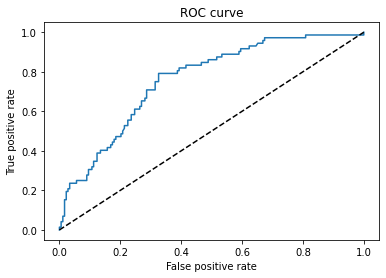

In [56]:
# get the values required to plot a ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
# plot the ROC curve
plt.plot(fpr, tpr)
# plot a secondary diagonal line, with dashed line style and black color to represent a no-skill classifier
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve');

In [57]:
# Calculate the Area Under the Receiver Operating Characteristic Curve (AUROC) on our test set
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
AUROC

0.7589731585518102

In [58]:
# calculate Gini from AUROC
Gini = AUROC * 2 - 1
Gini

0.5179463171036205

converter p pra odds
odds utiliza pra ter o score

In [59]:
y_hat_test_proba
#array com todas as ps de todos os usuarios analisados. considera todas as variaveis e todos os woes

array([0.70902931, 0.62637049, 0.58289259, 0.40039159, 0.36315527,
       0.56177417, 0.30975523, 0.59264696, 0.39514076, 0.28656497,
       0.46195465, 0.64204877, 0.13014852, 0.87452896, 0.83448523,
       0.64600942, 0.20364925, 0.22251143, 0.84169834, 0.65324986,
       0.43188597, 0.74954797, 0.2509072 , 0.14985846, 0.122816  ,
       0.54099495, 0.69638949, 0.62426655, 0.38059056, 0.11759825,
       0.41126719, 0.35576546, 0.29855428, 0.35717252, 0.20234951,
       0.46961723, 0.75471066, 0.20456495, 0.13926202, 0.89811669,
       0.39801195, 0.16665063, 0.51386597, 0.20932098, 0.38646878,
       0.43074565, 0.63140078, 0.62357371, 0.49777401, 0.47971088,
       0.82422438, 0.12799218, 0.54309466, 0.68090167, 0.430748  ,
       0.4237736 , 0.69479332, 0.71261379, 0.76260712, 0.26156703,
       0.31242962, 0.69837311, 0.60532611, 0.10552044, 0.44417988,
       0.43457623, 0.19086187, 0.67549016, 0.47746775, 0.39125772,
       0.54772368, 0.29890266, 0.49851522, 0.47056475, 0.77790

### Cálculo do Score

In [60]:
df_scorecard = pd.DataFrame(y_hat_test_proba, columns =['Probabilidade de Default'])
df_scorecard.head()

,Probabilidade de Default
0,0.709029
1,0.626370
2,0.582893
3,0.400392
4,0.363155


#### Nota importante: o score deve aumentar conforme a p diminui, entao vamos calcular o score para 1-p

In [61]:
df_scorecard['Probabilidade de Não Default'] = 1-df_scorecard['Probabilidade de Default']
df_scorecard.head()

,Probabilidade de Default,Probabilidade de Não Default
0,0.709029,0.290971
1,0.626370,0.373630
2,0.582893,0.417107
3,0.400392,0.599608
4,0.363155,0.636845


In [62]:
df_scorecard['Odds'] = df_scorecard['Probabilidade de Não Default']/(1-df_scorecard['Probabilidade de Não Default'])
df_scorecard.head()

,Probabilidade de Default,Probabilidade de Não Default,Odds
0,0.709029,0.290971,0.410379
1,0.626370,0.373630,0.596499
2,0.582893,0.417107,0.715582
3,0.400392,0.599608,1.497555
4,0.363155,0.636845,1.753643


Dado um pdo de 20 e um offset de 500/ Sendo mino 0 e maximo 1000

Offset is equal to the score that will be set in case of probability=0.5 or odds=1 (LN(odds)=0) , ou Seja, Offset = Score nessa situação

Para ter p 0.5 (ou seja, odds de 50:1) com pdo de 20, vamos definir que para estas Odds o modelo tera um score de 200

In [63]:
min_score = 0
max_score = 400

In [64]:
pdo = 20

In [65]:
factor = pdo/np.log(2)
factor

28.85390081777927

In [66]:
offset = 200 - (factor*np.log(50))
offset

87.1228762045055

In [67]:
df_scorecard['Score'] = offset + factor*(np.log(df_scorecard['Odds']))
df_scorecard.head()

,Probabilidade de Default,Probabilidade de Não Default,Odds,Score
0,0.709029,0.290971,0.410379,61.423448
1,0.626370,0.373630,0.596499,72.214719
2,0.582893,0.417107,0.715582,77.466654
3,0.400392,0.599608,1.497555,98.775055
4,0.363155,0.636845,1.753643,103.329979


In [68]:
df_scorecard.min()

Probabilidade de Default         0.078808
Probabilidade de Não Default     0.101883
Odds                             0.113441
Score                           24.323173
dtype: float64

In [69]:
df_scorecard.max()

Probabilidade de Default          0.898117
Probabilidade de Não Default      0.921192
Odds                             11.689129
Score                           158.064786
dtype: float64

In [70]:
lr.intercept_

array([-0.26058527])

Calculando o Score de cada variável

In [71]:
df_score_clean

,Variable,Cutoff,WoE,IV,Coeficientes
0,Sex,female,0.235341,0.017931,0.656714
1,Sex,male,-0.113035,0.008612,0.656714
0,Housing,free,0.472604,0.026106,0.797864
1,Housing,own,-0.194156,0.025795,0.797864
2,Housing,rent,0.404445,0.031393,0.797864
0,Checking account,NA,-1.176263,0.404410,0.840057
1,Checking account,little,0.818099,0.205693,0.840057
2,Checking account,moderate,0.401392,0.046447,0.840057
3,Checking account,rich,-0.405465,0.009461,0.840057
0,Agge_class,18-27,0.305191,0.028630,1.529863


In [72]:
lr.intercept_

array([-0.26058527])

In [73]:
score_intercept = factor*lr.intercept_ + offset
score_intercept

array([79.60397454])

summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]

In [74]:
df_score_clean['Score De cada Variavel'] =(-df_score_clean['WoE']*df_score_clean['Coeficientes'] + (lr.intercept_/41))*factor + (offset/41)
df_score_clean

,Variable,Cutoff,WoE,IV,Coeficientes,Score De cada Variavel
0,Sex,female,0.235341,0.017931,0.656714,-2.517856
1,Sex,male,-0.113035,0.008612,0.656714,4.083430
0,Housing,free,0.472604,0.026106,0.797864,-8.938497
1,Housing,own,-0.194156,0.025795,0.797864,6.411321
2,Housing,rent,0.404445,0.031393,0.797864,-7.369371
0,Checking account,NA,-1.176263,0.404410,0.840057,30.452905
1,Checking account,little,0.818099,0.205693,0.840057,-17.888265
2,Checking account,moderate,0.401392,0.046447,0.840057,-7.787741
3,Checking account,rich,-0.405465,0.009461,0.840057,11.769595
0,Agge_class,18-27,0.305191,0.028630,1.529863,-11.530334


### Aprovações

In [75]:
# Calculate Youden's J-Statistic to identify the best threshhold
J = tpr - fpr
# locate the index of the largest J
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best TPR Threshold: %f' % (best_thresh))

Best TPR Threshold: 0.480963


Baseando-se no teste J de Youdens, a probabilidade ideal que minimiza os FPR e maximiza os TPR de todas as amotas é na probabilidade de 0.480963. podemos confirmar olhando pra matrix de confurao

In [76]:
# update the threshold value
tr = best_thresh
# crate a new column for the predicted class based on predicted probabilities and threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.48 , 0.232],
       [0.064, 0.224]])

In [77]:
# create a new DF comprising of the thresholds from the ROC output
df_cutoffs = pd.DataFrame(thresholds, columns = ['thresholds'])
df_cutoffs

,thresholds
0,1.898117
1,0.898117
2,0.896727
3,0.874194
4,0.867798
5,0.841698
6,0.840223
7,0.824224
8,0.823154
9,0.810323


df_scorecard['Score'] = offset + factor*(np.log(df_scorecard['Odds']))

In [78]:
# calcue Score corresponding to each threshold
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds']))) * 
                       factor + offset).round()
df_cutoffs

C:\Users\MSPP\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

invalid value encountered in log



,thresholds,Score
0,1.898117,NaN
1,0.898117,150.0
2,0.896727,149.0
3,0.874194,143.0
4,0.867798,141.0
5,0.841698,135.0
6,0.840223,135.0
7,0.824224,132.0
8,0.823154,131.0
9,0.810323,129.0


In [79]:
# We define a function called 'n_approved' which assigns a value of 1 if a predicted probability
# is greater than the parameter p, which is a threshold, and a value of 0, if it is not.
# Then it sums the column.
# Thus, for given any percentage values, the function will return
# the number of rows wih estimated probabilites greater than the threshold. 
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

In [80]:
# Assuming that all credit applications above a given probability of being 'good' will be approved,
# when we apply the 'n_approved' function to a threshold, it will return the number of approved applications.
# Thus, here we calculate the number of approved appliations for al thresholds.
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
# Then, we calculate the number of rejected applications for each threshold.
# It is the difference between the total number of applications and the approved applications for that threshold.
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']
# Approval rate equalts the ratio of the approved applications and all applications.
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
# Rejection rate equals one minus approval rate.
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']
df_cutoffs.head()

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
0,1.898117,NaN,0,250,0.000,1.000
1,0.898117,150.0,1,249,0.004,0.996
2,0.896727,149.0,2,248,0.008,0.992
3,0.874194,143.0,4,246,0.016,0.984
4,0.867798,141.0,5,245,0.020,0.980


In [81]:
# let's have a look at the approval and rejection rates at our ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(0.47000, 0.50001)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
59,0.500002,87.0,110,140,0.440,0.560
60,0.497885,87.0,112,138,0.448,0.552
61,0.480963,85.0,115,135,0.460,0.540


In [82]:
df_cutoffs[df_cutoffs['thresholds'].between(0.42000, 0.47)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
62,0.453714,82.0,126,124,0.504,0.496
63,0.449716,81.0,127,123,0.508,0.492
64,0.444180,81.0,128,122,0.512,0.488
65,0.441587,80.0,129,121,0.516,0.484
66,0.431886,79.0,133,117,0.532,0.468
67,0.431386,79.0,134,116,0.536,0.464


In [83]:
df_cutoffs[df_cutoffs['thresholds'].between(0.5001, 0.5501)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
54,0.547724,93.0,97,153,0.388,0.612
55,0.546238,92.0,98,152,0.392,0.608
56,0.543095,92.0,99,151,0.396,0.604
57,0.539511,92.0,102,148,0.408,0.592
58,0.513277,89.0,107,143,0.428,0.572


### Expected Loss

Expected loss(EL) = Exposure at default(EAD) x Probability of default(PD) x Loss given default(LGD)

Temos pd

Loss Given Default: cenario mais critico e conservador é perder tudo (1), vamos considerar uma média de 70%, logo 0.7, recovery rate de 30%

Exposure At Default = valor no momento do default. Vamos considerar como temos 70% de bons pagadores na amostra que temos uma proporção de 30% entao. Para ter este valor o dataset precisaria conter mais informações sobre o pagamento. Dados como: dias desde o atraso. Ultima parcela paga, valor do montante(que temos) etc.

In [84]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,...,Purrpose_class,Crediit_amount_class,Age_class_woe,Savings_class_woe,Duration_class_woe,Purpose_class_woe,Credit_amount_woe,Checking_account_woe,Housing_woe,Sex_woe
0,67,male,2,own,NA,little,1169,6,radio_TV,0,...,radio_TV,932-1262,-0.009933,-0.704246,0.000000,-0.410063,0.000000,0.818099,-0.194156,-0.113035
1,22,female,2,own,little,moderate,5951,48,radio_TV,1,...,radio_TV,4720.0-7179.4,0.305191,0.271358,0.916291,-0.410063,0.357750,0.401392,-0.194156,0.235341
2,49,male,1,own,little,NA,2096,12,education,0,...,education,1906.8-2319.5,-0.009933,0.271358,-0.301325,0.399273,-0.305382,-1.176263,-0.194156,-0.113035
3,45,male,2,free,little,little,7882,42,furniture_equipment,0,...,furniture_equipment,7179.4-18424.0,-0.024573,0.271358,0.916291,0.095557,0.727154,0.818099,0.472604,-0.113035
4,53,male,2,free,little,little,4870,24,car,1,...,car,4720.0-7179.4,-0.009933,0.271358,-0.025642,0.068319,0.357750,0.818099,0.472604,-0.113035


In [85]:
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk', 'Agge_class',
       'Savings_class', 'Durration_class', 'Purrpose_class',
       'Crediit_amount_class', 'Age_class_woe', 'Savings_class_woe',
       'Duration_class_woe', 'Purpose_class_woe', 'Credit_amount_woe',
       'Checking_account_woe', 'Housing_woe', 'Sex_woe'],
      dtype='object')

In [86]:
#Creating the X and y variables
X_EL = df.drop('Risk', 1).values
y_EL = df["Risk"].values

# Spliting X and y into train and test version
X_train_EL, X_test_EL, y_train_EL, y_test_EL = train_test_split(X_EL, y_EL, test_size = 0.25, random_state=42)

In [87]:
X_train_EL = pd.DataFrame(X_train_EL, columns=['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose','Agge_class',
       'Savings_class', 'Durration_class', 'Purrpose_class',
       'Crediit_amount_class', 'Age_class_woe', 'Savings_class_woe',
       'Duration_class_woe', 'Purpose_class_woe', 'Credit_amount_woe',
       'Checking_account_woe', 'Housing_woe', 'Sex_woe'])
X_train_EL.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Agge_class,...,Purrpose_class,Crediit_amount_class,Age_class_woe,Savings_class_woe,Duration_class_woe,Purpose_class_woe,Credit_amount_woe,Checking_account_woe,Housing_woe,Sex_woe
0,24,female,1,rent,moderate,NA,1568,18,business,18-27,...,business,1479.4-1906.8,0.305191,0.139552,0.331832,0.230524,0.0,-1.176263,0.404445,0.235341
1,34,male,1,own,moderate,NA,1569,15,radio_TV,34-45,...,radio_TV,1479.4-1906.8,-0.024573,0.139552,-0.66529,-0.410063,0.0,-1.176263,-0.194156,-0.113035
2,27,male,2,own,little,little,5998,40,education,18-27,...,education,4720.0-7179.4,0.305191,0.271358,0.916291,0.399273,0.35775,0.818099,-0.194156,-0.113035
3,29,male,2,own,NA,NA,1169,18,radio_TV,28-33,...,radio_TV,932-1262,0.134083,-0.704246,0.331832,-0.410063,0.0,-1.176263,-0.194156,-0.113035
4,46,male,2,rent,little,moderate,1223,12,car,46+,...,car,932-1262,-0.009933,0.271358,-0.301325,0.068319,0.0,0.401392,0.404445,-0.113035


In [88]:
X_test_EL = pd.DataFrame(X_train_EL, columns=['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose','Agge_class',
       'Savings_class', 'Durration_class', 'Purrpose_class',
       'Crediit_amount_class', 'Age_class_woe', 'Savings_class_woe',
       'Duration_class_woe', 'Purpose_class_woe', 'Credit_amount_woe',
       'Checking_account_woe', 'Housing_woe', 'Sex_woe'])

In [89]:
COLUNAS = [
    'lr_prob_default',
    'lgd',
    'loan_amnt',
]

df_EL = pd.DataFrame(columns=COLUNAS)
#lr_preds = clf_logistic.predict_proba(X_test_US)
df_EL['lr_prob_default'] = y_hat_test_proba
df_EL['loan_amnt'] = X_test_EL.reset_index(drop = True)[['Credit amount']]
df_EL['lgd'] = 0.7
df_EL['loan_amnt_at_default'] = df_EL['loan_amnt']*0.5
df_EL['lr_expected_loss'] = df_EL['lr_prob_default'] * df_EL['lgd'] * df_EL['loan_amnt_at_default']

df_EL

,lr_prob_default,lgd,loan_amnt,loan_amnt_at_default,lr_expected_loss
0,0.709029,0.7,1568,784.0,389.115285
1,0.626370,0.7,1569,784.5,343.971356
2,0.582893,0.7,5998,2999.0,1223.66641
3,0.400392,0.7,1169,584.5,163.820218
4,0.363155,0.7,1223,611.5,155.448613
5,0.561774,0.7,2659,1329.5,522.815131
6,0.309755,0.7,700,350.0,75.890031
7,0.592647,0.7,2848,1424.0,590.750495
8,0.395141,0.7,1366,683.0,188.916799
9,0.286565,0.7,9055,4527.5,908.196042


In [90]:
montante_total = df_EL['lr_expected_loss'].sum()
montante_total

129322.03801348324